## scVI on Pan Fetal subsets

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

In [2]:
import torch
device = torch.device("cuda")

In [3]:
## import utils
cwd = '/home/jupyter/Pan_fetal_immune/src/utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

## Load and prep data

In [6]:
def load_data_split(data_dir, timestamp, split):
    # Load estimated gene dispersions for HVG selection
    # Generated running `Pan_fetal_immune/utils/PFI_pp_4_HVG_stats.py`
    adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split))

    ### Load count data
    adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    adata_raw.var_names_make_unique()

    # Load obs
    new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)
    adata_raw.obs = new_obs.loc[adata_raw.obs_names]

    ## Load var
    adata_raw.var = adata_lognorm_var.copy()

    ## Add batch key
    adata_raw.obs["bbk"] = adata_raw.obs["method"] + adata_raw.obs["donor"]
    return(adata_raw)

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)
    arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        )
    vae = scvi.model.SCVI(adata, n_latent=n_dims, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )
    return(vae)
    
# def save_scVI(adata, 
#               timestamp,
#               split,
#               n_hvgs = 5000,
#               remove_cc_genes = True,
#                 remove_tcr_bcr_genes = False,
#                 n_dims=20
#              ):
#     if remove_cc_genes:
#         cc = "removeCC"
#     else:
#         cc = "keepCC"
#     if remove_tcr_bcr_genes:
#         tcr = "removeTCRBCR"
#     else:
#         tcr = "keepTCRBCR"
#     outname = "PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.{h}HVGS.{cc}.{tcr}.{n}ldims.npy".format(t=timestamp, s=split, h=n_hvgs, cc=cc, tcr=tcr, n=n_dims)
#     np.save(data_dir + outname, adata.obsm["X_scVI"])

In [8]:
# data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/"
# timestamp = "20210429"
# split_ls = ["STROMA","MYELOID", "LYMPHOID", "MEM_PROGENITORS","HSC_IMMUNE","MYELOID_LYMPHOID"]
# for s in split_ls: 

def scvi_split(s, 
               data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/",
               timestamp = "20210429"
              ):
    adata_raw = load_data_split(data_dir, timestamp, s)
    adata_raw = prep_scVI(adata_raw, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)
    vae = train_scVI(adata_raw, n_dims=20)
    adata_raw.obsm["X_scVI"] = vae.get_latent_representation()
    ## Save embedding
    outname = "PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.npy".format(t=timestamp, s=s)
    np.save(data_dir + outname, adata_raw.obsm["X_scVI"])
    ## Plot convergence
    sns.set_context("talk")
    plt.plot(vae.history["elbo_train"], label="Training");
    plt.plot(vae.history["elbo_validation"], label="Validation");
    plt.legend();
    plt.xlabel("epoch");
    plt.ylabel("ELBO");
    plt.savefig("/home/jupyter/mount/gdrive/Pan_fetal/Updates_and_presentations/scvi_training_elbo_{s}.pdf".format(s=s), bbox_inches="tight")
    # save the reference model
    model_dir = 'scvi_{s}_model/'.format(s=s)
    if not os.path.exists(data_dir + model_dir):
        os.mkdir(data_dir + model_dir)
    vae.save(data_dir + model_dir, overwrite=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 318670 cells, 7499 vars, 33       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [12:27<00:00,  1.87s/it, loss=1.13e+03, v_num=1]


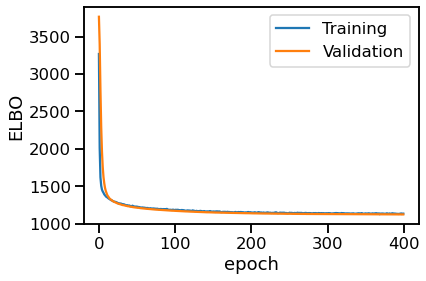

In [9]:
scvi_split("STROMA")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 241950 cells, 7500 vars, 33       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [11:04<00:00,  1.66s/it, loss=988, v_num=1]     


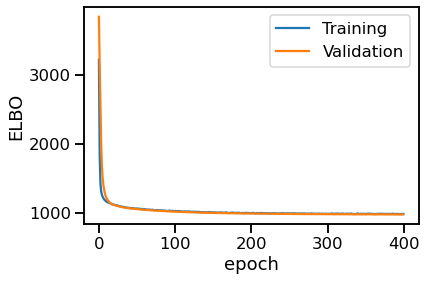

In [10]:
scvi_split("LYMPHOID")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 224708 cells, 7499 vars, 33       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:52<00:00,  1.63s/it, loss=1.14e+03, v_num=1]


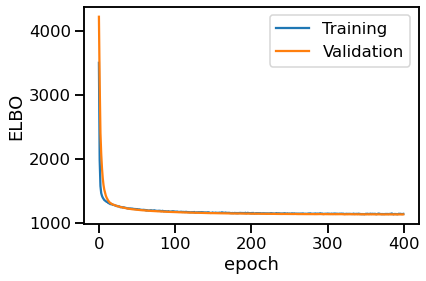

In [11]:
scvi_split("MYELOID")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 149239 cells, 7499 vars, 33       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [09:33<00:00,  1.43s/it, loss=993, v_num=1]     


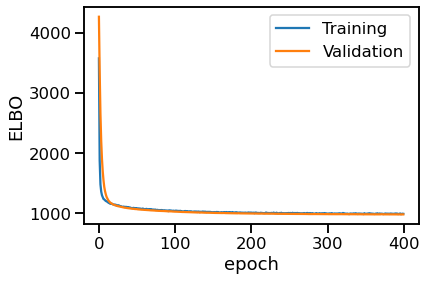

In [12]:
scvi_split("MEM_PROGENITORS")